### Mask & No Mask Face Detection 

## Download YOLO Algrithm Files.

In [2]:
!git clone https://github.com/ultralytics/yolov5  # clone
!pip install -qr yolov5/requirements.txt  # install

Cloning into 'yolov5'...
remote: Enumerating objects: 12169, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 12169 (delta 0), reused 2 (delta 0), pack-reused 12167
Receiving objects: 100% (12169/12169), 11.93 MiB | 17.14 MiB/s, done.
Resolving deltas: 100% (8427/8427), done.


In [3]:
import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime
import xml.etree.ElementTree as ET 
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Anotation Read and Handling.

In [4]:
path_an = "../input/face-mask-detection/annotations"

In [5]:
dataset = {
            "file":[],
            "name":[],    
            "width":[],
            "height":[],
            "xmin":[],
            "ymin":[],   
            "xmax":[],
            "ymax":[],
           }

In [6]:
for anno in glob.glob(path_an+"/*.xml"):
    tree = ET.parse(anno)
    
    for elem in tree.iter():
        if 'size' in elem.tag:
            for attr in list(elem):
                if 'width' in attr.tag: 
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))    

        if 'object' in elem.tag:
            for attr in list(elem):
                
                if 'name' in attr.tag:
                    name = attr.text                 
                    dataset['name']+=[name]
                    dataset['width']+=[width]
                    dataset['height']+=[height] 
                    dataset['file']+=[anno.split('/')[-1][0:-4]] 
                            
                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            dataset['xmin']+=[xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            dataset['ymin']+=[ymin]                                
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            dataset['xmax']+=[xmax]                                
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            dataset['ymax']+=[ymax]

In [7]:
df=pd.DataFrame(dataset)
df.head()

,file,name,width,height,xmin,ymin,xmax,ymax
0,maksssksksss737,with_mask,400,226,28,55,46,71
1,maksssksksss737,with_mask,400,226,98,62,111,78
2,maksssksksss737,mask_weared_incorrect,400,226,159,50,193,90
3,maksssksksss737,with_mask,400,226,293,59,313,80
4,maksssksksss737,with_mask,400,226,352,51,372,72


In [8]:
name_dict = {
    'with_mask': 0,
    'mask_weared_incorrect': 1,
    'without_mask': 2 
}

In [9]:
df['class'] = df['name'].map(name_dict)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072 entries, 0 to 4071
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    4072 non-null   object
 1   name    4072 non-null   object
 2   width   4072 non-null   int64 
 3   height  4072 non-null   int64 
 4   xmin    4072 non-null   int64 
 5   ymin    4072 non-null   int64 
 6   xmax    4072 non-null   int64 
 7   ymax    4072 non-null   int64 
 8   class   4072 non-null   int64 
dtypes: int64(7), object(2)
memory usage: 286.4+ KB


In [12]:
np.sort(df.name.unique())

array(['mask_weared_incorrect', 'with_mask', 'without_mask'], dtype=object)

## Split Data to Train, Validation, and Test.

In [13]:
fileNames = [*os.listdir("../input/face-mask-detection/images")]
len(fileNames)

853

In [14]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(fileNames, test_size=0.1, random_state=22)
test, val = train_test_split(test, test_size=0.7, random_state=22)
print("Length of Train =",len(train))
print("="*30)
print("Length of Valid =",len(val))
print("="*30)
print("Length of test =", len(test))

Length of Train = 767
Length of Valid = 61
Length of test = 25


In [17]:
os.mkdir('./yolov5/data/train')
os.mkdir('./yolov5/data/val')
os.mkdir('./yolov5/data/test')
os.mkdir('./yolov5/data/train/images')
os.mkdir('./yolov5/data/train/labels')
os.mkdir('./yolov5/data/test/images')
os.mkdir('./yolov5/data/test/labels')
os.mkdir('./yolov5/data/val/images')
os.mkdir('./yolov5/data/val/labels')

In [18]:
from PIL import Image

def copyImages(imageList, folder_Name):
    for image in imageList:
        img = Image.open("../input/face-mask-detection/images/"+image)
        img1 = img.resize((640, 480))
        _ = img1.save("./yolov5/data/"+folder_Name+"/images/"+image)
        

In [19]:
# Split the model to different folder
copyImages(train, "train")
copyImages(val, "val")
copyImages(test, "test")

In [20]:
df.head()

,file,name,width,height,xmin,ymin,xmax,ymax,class
0,maksssksksss737,with_mask,400,226,28,55,46,71,0
1,maksssksksss737,with_mask,400,226,98,62,111,78,0
2,maksssksksss737,mask_weared_incorrect,400,226,159,50,193,90,1
3,maksssksksss737,with_mask,400,226,293,59,313,80,0
4,maksssksksss737,with_mask,400,226,352,51,372,72,0


In [21]:
# Since the picture of the model have been changed, 
# the annotation need to been switch also
df['xmax'] = (640/df['width'])*df['xmax']
df['ymax'] = (480/df['height'])*df['ymax']
df['xmin'] = (640/df['width'])*df['xmin']
df['ymin'] = (480/df['height'])*df['ymin']

In [22]:
# Specify the type of the df
df[['xmax', 'ymax', 'xmin', 'ymin']] = df[['xmax', 'ymax', 'xmin', 'ymin']].astype('int64')

In [23]:
# x_center: means the portion that the center of x in the picture
# y_center: means the portion that the center of y in the picture
# box_height: the portion of the height in the picture
# box_width: the portion of the width in the picture
df['x_center'] = (df['xmax']+df['xmin'])/(2*640)
df['y_center'] = (df['ymax']+df['ymin'])/(2*480)
df['box_height'] = (df['xmax']-df['xmin'])/(640)
df['box_width'] = (df['ymax']-df['ymin'])/(480)

In [24]:
df.head()

,file,name,width,height,xmin,ymin,xmax,ymax,class,x_center,y_center,box_height,box_width
0,maksssksksss737,with_mask,400,226,44,116,73,150,0,0.091406,0.277083,0.045312,0.070833
1,maksssksksss737,with_mask,400,226,156,131,177,165,0,0.260156,0.308333,0.032813,0.070833
2,maksssksksss737,mask_weared_incorrect,400,226,254,106,308,191,1,0.439063,0.309375,0.084375,0.177083
3,maksssksksss737,with_mask,400,226,468,125,500,169,0,0.756250,0.306250,0.050000,0.091667
4,maksssksksss737,with_mask,400,226,563,108,595,152,0,0.904687,0.270833,0.050000,0.091667


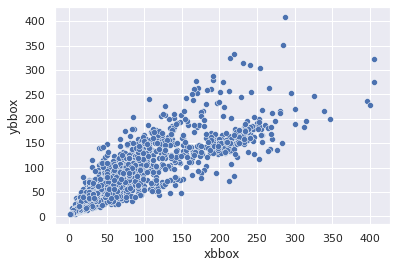

In [25]:
# Plot the size of the box of all picture
df['xbbox'] = df['xmax']-df['xmin']
df['ybbox'] = df['ymax']-df['ymin']

sns.set()
sns.scatterplot(x='xbbox',  y='ybbox', data=df)
plt.show()

In [26]:
# Change all data to string type for the further writting to the file
df = df.astype('string')

In [27]:
# Split the data to the target folder after the preprocessing
def create_labels(image_list, data_name):
    fileNames = [x.split(".")[0] for x in image_list]

    for name in fileNames:
        data = df[df.file==name]
        box_list = []
        
        for index in range(len(data)):
            row = data.iloc[index]
            box_list.append(row['class']+" "+row["x_center"]+" "+row["y_center"]\
                        +" "+row["box_height"]+" "+row["box_width"])
            
        text = "\n".join(box_list)
        with open("./yolov5/data/"+data_name+"/labels/"+name+".txt", "w") as file:
            file.write(text)        

In [28]:
create_labels(train, "train")
create_labels(val, "val")
create_labels(test, "test")

In [29]:
%cd yolov5

/kaggle/working/yolov5


## Configuration Model.

In [30]:
from IPython.display import Image, Video, clear_output  # to display images
import torch
from yolov5 import utils
display = utils.notebook_init()

YOLOv5 🚀 v6.1-243-g7cef03d Python-3.7.12 torch-1.9.1 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)


Setup complete ✅ (2 CPUs, 15.6 GB RAM, 3534.2/4030.7 GB disk)


In [31]:
yaml_text = """train: data/train/images
val: data/train/images

nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']"""

In [32]:
with open("data/data.yaml", 'w') as file:
    file.write(yaml_text)

In [33]:
%cat data/data.yaml

train: data/train/images
val: data/train/images

nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']

In [34]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [35]:
%%writetemplate models/custom_yolov5s.yaml

# parameters
nc: 3  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
    - [10,13, 16,30, 33,23]  # P3/8
    - [30,61, 62,45, 59,119]  # P4/16
    - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
    [[-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
    [[-1, 6], 1, Concat, [1]],  # cat backbone P4
    [-1, 3, BottleneckCSP, [512, False]],  # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
    [[-1, 4], 1, Concat, [1]],  # cat backbone P3
    [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]],  # cat head P4
    [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]],  # cat head P5
    [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

    [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
    ]

## Train Model

In [36]:
# train yolov5s on custom data for 100 epochs
# time its performance

start = datetime.now()
!python train.py --img 640 --batch 32 --epochs 100 --data data/data.yaml --cfg models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache
end = datetime.now()

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=, cfg=models/custom_yolov5s.yaml, data=data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-243-g7cef03d Python-3.7.12 torch-1.9.1 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.0

In [37]:
print("Runtime =",end-start)

Runtime = 0:42:11.046459


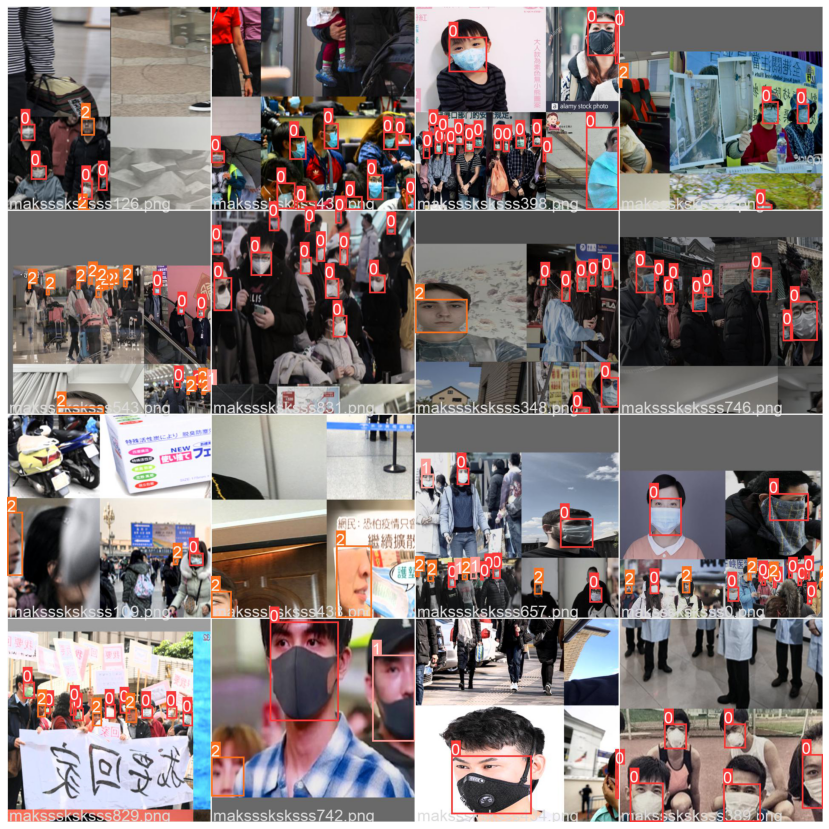

In [38]:
img = plt.imread('runs/train/yolov5s_results/train_batch0.jpg')
plt.figure(figsize=(20,15))
plt.imshow(img)
plt.axis('off')
plt.show()

## Evaluation Model

In [39]:
!python detect.py --source data/test/images/ --weight runs/train/yolov5s_results/weights/best.pt --name expTestImage --conf 0.4

detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=data/test/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=expTestImage, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-243-g7cef03d Python-3.7.12 torch-1.9.1 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7251912 parameters, 0 gradients, 16.8 GFLOPs
image 1/25 /kaggle/working/yolov5/data/test/images/maksssksksss151.png: 480x640 10 with_masks, Done. (0.011s)
image 2/25 /kaggle/working/yolov5/data/test/images/maksssksksss164.png: 480x640 6 with_masks, 3 without_masks, Done. (0.009s)
image 3/25 /kaggle/working/yolov5/data/test/images/maksssksksss173.png: 480x640 2 with_masks

In [40]:
color_dict = {
    'with_mask': (0, 255, 0),
    'mask_weared_incorrect':  (0, 0, 255),
    'without_mask': (255, 0, 0) 
}

In [41]:
def show_image(img_id):
    df_image = df[df.file==img_id]
    df_image[['xmin', 'ymin', 'xmax', 'ymax']] = df_image[['xmin', 'ymin', 'xmax', 'ymax']].astype('int64')
    path = 'data/test/images/'+img_id+'.png'
    img = plt.imread(path)

    imge = img.copy()

    for index in range(len(df_image)):
        row = df_image.iloc[index]
        cv2.rectangle(imge, 
                      (row['xmin'], row['ymin']),
                      (row['xmax'], row['ymax']),
                      color=color_dict[row['name']],
                      thickness=2)

    img_pred = plt.imread('runs/detect/expTestImage/'+img_id+".png")
    # ===================================
    plt.figure(figsize=(14,17))

    plt.subplot(1,2,1)
    plt.imshow(imge)
    plt.axis('off')
    plt.title('Image with Truth Box')

    plt.subplot(1,2,2)
    plt.imshow(img_pred)
    plt.axis('off')
    plt.title('Image with Predicted Box')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


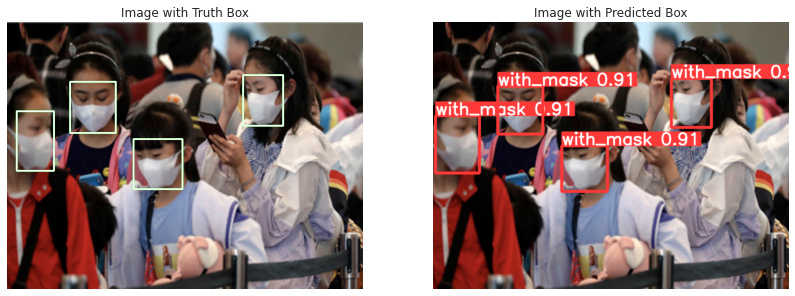

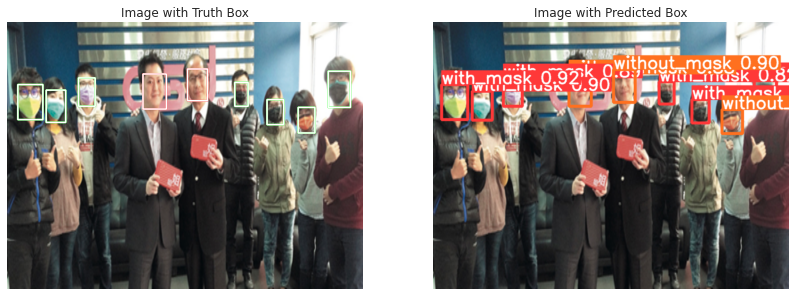

In [42]:
show_image("maksssksksss466") 
show_image("maksssksksss164") 
plt.show()